# Assignment 1 - Mini Batch SGD for Linear Image Classification


In this exercise you will:
    
- implement a **loss function** for a linear classifier
- **optimize** the loss function with **SGD**
- use a validation set to **tune the hyperparameter (learning rate, regularization strength, regularization type, mini batch size.)**
- **visualize** the final learned weights

# Download your dataset


Before starting you should download and set your dataset.

1) Download from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

2) Extract the .tar.gz file into your assignment1/datasets folder

3) Check that the 8 files of the dataset are in the folder **assignment1/datasets/cifar-10-batches-py/**

4) You may find useful information about the dataset in the readme.html of that folder

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from classUtils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This makes matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ImportError: No module named classUtils.data_utils

## CIFAR-10 Data Loading and Preprocessing

In [143]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000L, 32L, 32L, 3L)
Training labels shape:  (50000L,)
Test data shape:  (10000L, 32L, 32L, 3L)
Test labels shape:  (10000L,)


random image number:  45183 image category:  truck


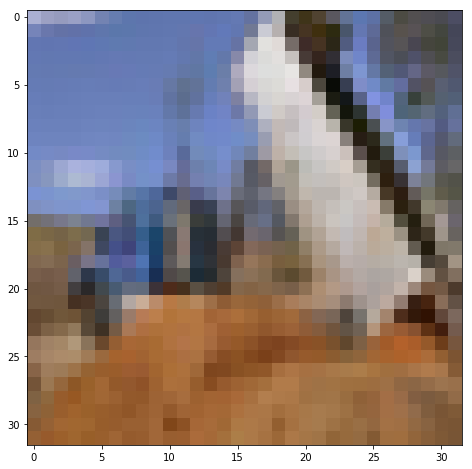

In [144]:
#CSFAK debug 
imcat = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
t = np.random.randint(0,len(y_train))
plt.imshow(X_train[t]/255)

print 'random image number: ', t, 'image category: ', imcat[y_train[t]] 

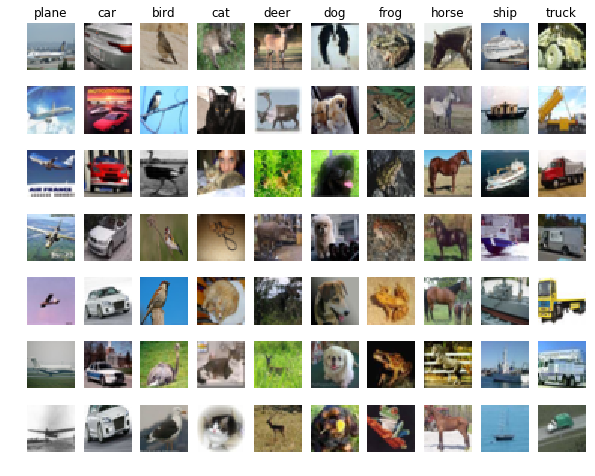

In [145]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [146]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 32L, 32L, 3L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 32L, 32L, 3L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


In [147]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000L, 3072L)
Validation data shape:  (1000L, 3072L)
Test data shape:  (1000L, 3072L)
dev data shape:  (500L, 3072L)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


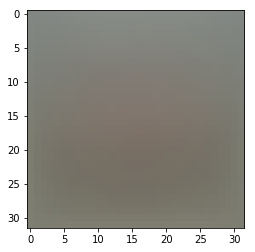

In [148]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [149]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [150]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000L, 3073L) (1000L, 3073L) (1000L, 3073L) (500L, 3073L)


## 1. Stochastic Gradient Descent

Your code for this section will all be written inside **compute_gradient_and_loss.py**.

-As a ﬁrst step, you will need to correctly fill-in the method 'compute_gradient_and_loss' that takes as input a set of training samples and computes the loss and the gradient of the loss (for the given training samples). 

-You will call this function inside the **train_linear_classifer method** of the **LinearClassifier Class** in the  **linear_classifier.py** file in order to compute the gradient of each mini-batch, and for collecting the sequence of all mini-batch losses during training as well as the sequence of all validation losses during training.

In [151]:
# Check that the implementation of the compute_gradient_and_loss function is ok by calling it directly using random W as input.
from classUtils.classifiers.compute_gradient_loss import *
import time

# generate a random classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = compute_gradient_and_loss(W, X_dev, y_dev, 0.00001, 2, 0)
print 'loss: %f' % (loss, )

loss: 727.543824


## 2. Implement your linear classifier

To implement your linear classifier, you will need to fill-in the following
two functions: 

'train_linear_classifier': this is the method of class LinearClassifier responsible for training the
classiﬁer using mini-batch SGD. It should return the parameters of the
trained classiﬁer and the sequence of all mini-batch losses during training
as well as the sequence of all validation losses during training.

'predict_image_class': this is the method of class LinearClassifier  takes as input an image and uses a
trained classiﬁer to predict its class (recall that the predicted class should
be the one that is assigned the maximum score by the trained classifer).

In [152]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train_linear_classifier() and then run it with the code below.
# Plot the loss of the training process as a function of iteration number.

from classUtils.classifiers import LinearClassifier
cifarLC = LinearClassifier()
tic = time.time()

loss_hist, val_loss_hist = cifarLC.train_linear_classifier(X_train, y_train, X_val, y_val, learning_rate=1e-7, reg=5e4, \
                                        reg_type = 2, num_epochs=6, batch_size = 200, num_valid_loss_evals = 100, verbose=True)
toc = time.time()
print 'Time elapsed: %f secs' % (toc - tic)

# A useful debugging strategy is to plot the loss as a function of iteration number !

iteration No 0 / 1470: loss 2691.682782
iteration No 100 / 1470: loss 617.282037
iteration No 200 / 1470: loss 279.429636
iteration No 300 / 1470: loss 216.760386
iteration No 400 / 1470: loss 205.768187
iteration No 500 / 1470: loss 202.550468
iteration No 600 / 1470: loss 203.975472
iteration No 700 / 1470: loss 203.790827
iteration No 800 / 1470: loss 203.967665
iteration No 900 / 1470: loss 207.592006
iteration No 1000 / 1470: loss 203.008128
iteration No 1100 / 1470: loss 203.505710
iteration No 1200 / 1470: loss 205.276948
iteration No 1300 / 1470: loss 207.507687
iteration No 1400 / 1470: loss 205.442001
CSFAK INSIDE train_linear_classifier
Time elapsed: 65.291000 secs


In [153]:
# Implement the LinearClassifier.predict_image_class function and evaluate the performance on both the
# training and validation set
y_train_pred = cifarLC.predict_image_class(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )

y_val_pred = cifarLC.predict_image_class(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

CSFAK INSIDE predict_image_class
training accuracy: 0.289980
CSFAK INSIDE predict_image_class
validation accuracy: 0.298000


### 3. Choose the best hyperparameters using the validation set

You will use the validation set in order to choose proper values for some of the hyperparameters of the problem 
(these include the regularization strength, the mini-batch size, learning rate and the type of regularization l1 or l2). 

To that end, you will train linear classiﬁers for a diﬀerent number of combinations of these hyperparameters
and you will choose as your ﬁnal classiﬁer the one that achieves the highest accuracy in the validation set.

In [154]:
# Use the validation set to tune hyperparameters (regularization type and strength, learning rate and batch size). 
# You can run your experiments using the following 8 combinations (columnwise) 
# You are encouraged to use your own combinations on different ranges of the hyperparameters to achieve the highest accuracy.
# If you are careful you should be able to get a classification accuracy of about 0.4 on the validation set.
learning_rates          = [1e-8, 1e-7, 3e-7, 3e-7, 5e-7, 8e-7, 1e-6, 1e-5]
regularization_strengths= [1e4,  3e4,  5e4,   1e4, 8e4,  1e5,  5e4,  5e5 ]
regularization_type     = [1,      2,    1,     2,   1,    2,    1,    2 ] # 1,2 for l1, l2 respectively
batch_size              = [50,   100,  200,   400, 100,  200,  200,  400 ]
num_epochs = 6

# results is a container for saving the results of your cross-validation
# HINT : you can use a dictionary for mapping tuples of the form
# (learning_rate, regularization_strength, regularization_type, batch_size) 
# to tuples of the form (training_accuracy, validation_accuracy). 
# The accuracy is simply the fraction of data points that are correctly classified.
results = []
best_train_val = -1   # The highest training accuracy that we have seen so far.
best_valid_val = -1   # The highest validation accuracy that we have seen so far.
best_classifier = None # The LinearClassifier object that achieved the highest validation rate.
best_lr = best_reg = best_reg_type = best_batch_size = 0 
################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For some combinations of hyperparameters, train a linear clasifier on   #
# the training set, compute its accuracy on the training and validation sets,  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearClassifier object that achieves#
# this accuracy in best_classifier.                                            #
# !!! Also, print out or plot the resulting accuracy for the selected          #
# combinations of your hyperparameters.                                        #
################################################################################
#pass
best_loss_hist = best_val_loss_hist = [] # this is for keeping the best train and validation loss history list
for i in range(len(learning_rates)):     # for every hyperparameters combination set
    cifarLC = LinearClassifier()         # make an instance of the object LinearClassifier
    # train the model according to choosen hyperparameters
    loss_hist, val_loss_hist = cifarLC.train_linear_classifier(X_train, y_train, X_val, y_val, learning_rate = learning_rates[i], reg = regularization_strengths[i], reg_type = regularization_type[i], num_epochs=6, batch_size = batch_size[i], num_valid_loss_evals = 100, verbose=True)
    y_train_pred = cifarLC.predict_image_class(X_train) # make a prediction with the train set
    train_accuracy = np.mean(y_train == y_train_pred)   # calculate the train accuracy
    y_val_pred = cifarLC.predict_image_class(X_val)     # make a prediction with the validation set
    val_accuracy = np.mean(y_val == y_val_pred)         # calculate the validation accuracy
    results.append((train_accuracy, val_accuracy))      # keep the history of the accuracy
    
    
    if train_accuracy > best_train_val:                 # keep the best train accuracy
        best_train_val = train_accuracy
            
    if val_accuracy > best_valid_val:                   # for best validation set:
        best_valid_val = val_accuracy                   # keep the accuracy 
        best_classifier = cifarLC                       # keep the object instance
        best_lr = learning_rates[i]                     # keep the learning_rate   
        best_reg = regularization_strengths[i]          # keep regularization_strength 
        best_reg_type = regularization_type[i]          # regularization_type
        best_batch_size = batch_size[i]                 # batch_size
        best_loss_hist = loss_hist                      # loss_hist
        best_val_loss_hist = val_loss_hist              # val_loss_hist
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
print 'best training and validation accuracy achieved during cross-validation: %f and %f' % (best_train_val,best_valid_val)
print 'using parameters: lr %e reg %e reg_type %d and batch_size %d' % (best_lr, best_reg, best_reg_type, best_batch_size)

iteration No 0 / 5880: loss 246370.202264
iteration No 100 / 5880: loss 15562.920590
iteration No 200 / 5880: loss 15560.606219
iteration No 300 / 5880: loss 15562.330480
iteration No 400 / 5880: loss 15557.036454
iteration No 500 / 5880: loss 15555.997562
iteration No 600 / 5880: loss 15550.702632
iteration No 700 / 5880: loss 15550.462497
iteration No 800 / 5880: loss 15548.128606
iteration No 900 / 5880: loss 15549.353141
iteration No 1000 / 5880: loss 15547.165254
iteration No 1100 / 5880: loss 15542.069776
iteration No 1200 / 5880: loss 15539.823354
iteration No 1300 / 5880: loss 15536.556723
iteration No 1400 / 5880: loss 15533.220613
iteration No 1500 / 5880: loss 15527.925293
iteration No 1600 / 5880: loss 15521.904826
iteration No 1700 / 5880: loss 15517.451961
iteration No 1800 / 5880: loss 15513.938482
iteration No 1900 / 5880: loss 15505.172147
iteration No 2000 / 5880: loss 15503.630186
iteration No 2100 / 5880: loss 15495.964967
iteration No 2200 / 5880: loss 15493.044424

iteration No 0 / 735: loss 17234.609965
iteration No 100 / 735: loss 1057969373219056525325427396268223143268589829452692950817767538335888633121636701027665329736238952370592940748116573498431712901043892692106691763063099137267916648427501752114205343917350584320.000000


classUtils\classifiers\compute_gradient_loss.py:232: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(np.abs(W))   # l1, reg is actually lambda regularization strength
classUtils\classifiers\compute_gradient_loss.py:232: RuntimeWarning: invalid value encountered in double_scalars
  loss += reg * np.sum(np.abs(W))   # l1, reg is actually lambda regularization strength
classUtils\classifiers\compute_gradient_loss.py:232: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(np.abs(W))   # l1, reg is actually lambda regularization strength


iteration No 200 / 735: loss inf
iteration No 300 / 735: loss inf


classUtils\classifiers\compute_gradient_loss.py:216: RuntimeWarning: overflow encountered in double_scalars
  
classUtils\classifiers\compute_gradient_loss.py:242: RuntimeWarning: overflow encountered in multiply
  
classUtils\classifiers\linear_classifier.py:91: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate*grad # grad is augmented according to given formula insude the compute_gradient_and_loss function


iteration No 400 / 735: loss nan
iteration No 500 / 735: loss nan
iteration No 600 / 735: loss nan
iteration No 700 / 735: loss nan
CSFAK INSIDE train_linear_classifier
CSFAK INSIDE predict_image_class
CSFAK INSIDE predict_image_class
best training and validation accuracy achieved during cross-validation: 0.332143 and 0.329000
using parameters: lr 1.000000e-07 reg 3.000000e+04 reg_type 2 and batch_size 100


### 4. Test your best classifier and visualize the learnt weights

For the ﬁnal classiﬁer, you should 

1) draw (in the same plot) the sequence of mini-batch losses and validation losses  collected during training. 

2) Evaluate the classiﬁer on the test set and report the achieved test accuracy

3) visualize (as images) the weights W (one image per row of W).

Text(0.5,0,'Iterations')

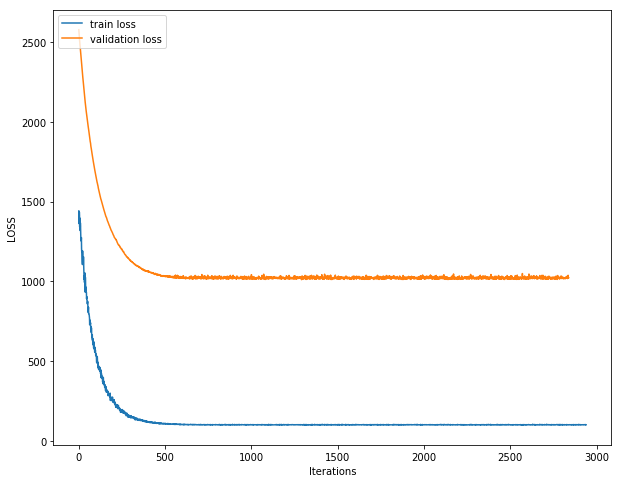

In [155]:
################################################################################
# TODO:  Get the mini-batch training losses and validation losses collected    #
# during training of your best classifier and plot in the same plot            #
################################################################################
#pass
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.plot(range(len(best_loss_hist)), best_loss_hist, label='train loss')
ax.plot(range(len(best_val_loss_hist)), best_val_loss_hist, label='validation loss')

ax.legend(loc=2)
plt.ylabel('LOSS')
plt.xlabel('Iterations')
#ax.draw()

In [156]:
###################################################################################
# TODO:  Evaluate the best_classifier on the test set and plot/print the accuracy #
###################################################################################
test_accuracy = 0
y_test_pred = best_classifier.predict_image_class(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear classifier on raw pixels final test set accuracy: %f' % test_accuracy

CSFAK INSIDE predict_image_class
linear classifier on raw pixels final test set accuracy: 0.327000


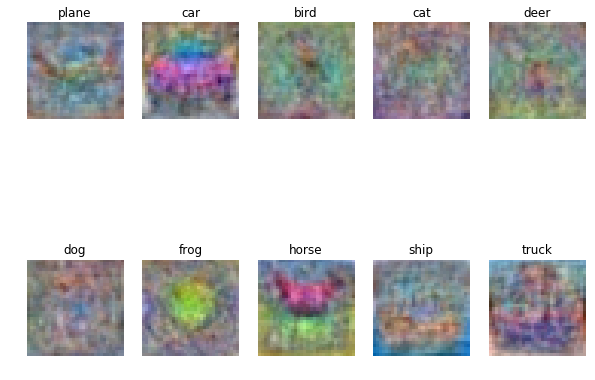

In [157]:
# Visualize the learned weights for each class.
#IF you have calculated valid W weights just the following routine will visualize the learned weights
#Just run the following lines of code

w = best_classifier.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])